
# Utility routines for benchmarks on OT solvers


In [1]:
# https://www.kernel-operations.io/geomloss/_auto_examples/performances/plot_benchmarks_ot_3D.html#sphx-glr-auto-examples-performances-plot-benchmarks-ot-3d-py

import time
import torch
import numpy as np

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
numpy = lambda x: x.detach().cpu().numpy()

## 3D dataset

Reading **.ply** files:



In [2]:
from plyfile import PlyData, PlyElement


def load_ply_file(fname, offset=[-0.011, 0.109, -0.008], scale=0.04):
    """Loads a .ply mesh to return a collection of weighted Dirac atoms: one per triangle face."""

    # Load the data, and read the connectivity information:
    plydata = PlyData.read(fname)
    triangles = np.vstack(plydata["face"].data["vertex_indices"])

    # Normalize the point cloud, as specified by the user:
    points = np.vstack([[x, y, z] for (x, y, z) in plydata["vertex"]])
    points -= offset
    points /= 2 * scale

    # Our mesh is given as a collection of ABC triangles:
    A, B, C = points[triangles[:, 0]], points[triangles[:, 1]], points[triangles[:, 2]]

    # Locations and weights of our Dirac atoms:
    X = (A + B + C) / 3  # centers of the faces
    S = np.sqrt(np.sum(np.cross(B - A, C - A) ** 2, 1)) / 2  # areas of the faces

    print(
        "File loaded, and encoded as the weighted sum of {:,} atoms in 3D.".format(
            len(X)
        )
    )

    # We return a (normalized) vector of weights + a "list" of points
    return tensor(S / np.sum(S)), tensor(X)

Synthetic sphere - a typical source measure:



In [3]:
def create_sphere(n_samples=1000):
    """Creates a uniform sample on the unit sphere."""
    n_samples = int(n_samples)

    indices = np.arange(0, n_samples, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / n_samples)
    theta = np.pi * (1 + 5 ** 0.5) * indices

    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
    points = np.vstack((x, y, z)).T
    weights = np.ones(n_samples) / n_samples

    return tensor(weights), tensor(points)

Simple (slow) display routine:



In [4]:
def display_cloud(ax, measure, color):

    w_i, x_i = numpy(measure[0]), numpy(measure[1])

    ax.view_init(elev=110, azim=-90)
    # ax.set_aspect('equal')

    weights = w_i / w_i.sum()
    ax.scatter(x_i[:, 0], x_i[:, 1], x_i[:, 2], s=25 * 500 * weights, c=color)

    ax.axes.set_xlim3d(left=-1.4, right=1.4)
    ax.axes.set_ylim3d(bottom=-1.4, top=1.4)
    ax.axes.set_zlim3d(bottom=-1.4, top=1.4)

## Measuring the error made on the marginal constraints

Computing the marginals of the implicit transport plan:

\begin{align}\pi ~&=~ \exp \tfrac{1}{\varepsilon}( f\oplus g - \text{C})~\cdot~ \alpha\otimes\beta,\\
  \text{i.e.}~~\pi_{x_i \leftrightarrow y_j}~&=~ \exp \tfrac{1}{\varepsilon}( F_i + G_j - \text{C}(x_i,y_j))~\cdot~ \alpha_i \beta_j.\end{align}





In [5]:
from pykeops.torch import LazyTensor


def plan_marginals(blur, a_i, x_i, b_j, y_j, F_i, G_j):
    """Returns the marginals of the transport plan encoded in the dual vectors F_i and G_j."""

    x_i = LazyTensor(x_i[:, None, :])
    y_j = LazyTensor(y_j[None, :, :])
    F_i = LazyTensor(F_i[:, None, None])
    G_j = LazyTensor(G_j[None, :, None])

    # Cost matrix:
    C_ij = ((x_i - y_j) ** 2).sum(-1) / 2

    # Scaled kernel matrix:
    K_ij = ((F_i + G_j - C_ij) / blur ** 2).exp()

    A_i = a_i * (K_ij @ b_j)  # First marginal
    B_j = b_j * (K_ij.t() @ a_i)  # Second marginal

    return A_i, B_j

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


Compare the marginals using the relevant kernel norm

\begin{align}\|\alpha - \beta\|^2_{k_\varepsilon} ~=~
  \langle \alpha - \beta , k_\varepsilon \star (\alpha -\beta) \rangle,\end{align}

with $k_\varepsilon(x,y) = \exp(-\text{C}(x,y)/\varepsilon)$.




In [6]:
def blurred_relative_error(blur, x_i, a_i, A_i):
    """Computes the relative error |A_i-a_i| / |a_i| with respect to the kernel norm k_eps."""

    x_j = LazyTensor(x_i[None, :, :])
    x_i = LazyTensor(x_i[:, None, :])

    C_ij = ((x_i - x_j) ** 2).sum(-1) / 2
    K_ij = (-C_ij / blur ** 2).exp()

    squared_error = (A_i - a_i).dot(K_ij @ (A_i - a_i))
    squared_norm = a_i.dot(K_ij @ a_i)

    return (squared_error / squared_norm).sqrt()

Simple error routine:



In [7]:
def marginal_error(blur, a_i, x_i, b_j, y_j, F_i, G_j, mode="blurred"):
    """Measures how well the transport plan encoded in the dual vectors F_i and G_j satisfies the marginal constraints."""

    A_i, B_j = plan_marginals(blur, a_i, x_i, b_j, y_j, F_i, G_j)

    if mode == "TV":
        # Return the (average) total variation error on the marginal constraints:
        return ((A_i - a_i).abs().sum() + (B_j - b_j).abs().sum()) / 2

    elif mode == "blurred":
        # Use the kernel norm k_eps to measure the discrepancy
        norm_x = blurred_relative_error(blur, x_i, a_i, A_i)
        norm_y = blurred_relative_error(blur, y_j, b_j, B_j)
        return (norm_x + norm_y) / 2

    else:
        raise NotImplementedError()

## Computing the entropic Wasserstein distance

Computing the transport cost, assuming that the dual vectors satisfy
the equations at optimality:

\begin{align}\text{OT}_\varepsilon(\alpha,\beta)~=~ \langle \alpha, f^\star\rangle + \langle \beta, g^\star \rangle.\end{align}




In [8]:
def transport_cost(a_i, b_j, F_i, G_j):
    """Returns the entropic transport cost associated to the dual variables F_i and G_j."""
    return a_i.dot(F_i) + b_j.dot(G_j)

Compute the "entropic Wasserstein distance"

\begin{align}\text{D}_\varepsilon(\alpha,\beta)~=~ \sqrt{2 \cdot \text{OT}_\varepsilon(\alpha,\beta)},\end{align}

which is **homogeneous to a distance on the ambient space** and is
associated to the (biased) Sinkhorn cost $\text{OT}_\varepsilon$
with cost $\text{C}(x,y) = \tfrac{1}{2}\|x-y\|^2$.



In [9]:
def wasserstein_distance(a_i, b_j, F_i, G_j):
    """Returns the entropic Wasserstein "distance" associated to the dual variables F_i and G_j."""
    return (2 * transport_cost(a_i, b_j, F_i, G_j)).sqrt()

Compute all these quantities simultaneously, with a proper clock:



In [10]:
def benchmark_solver(OT_solver, blur, source, target):
    """Returns a (timing, relative error on the marginals, wasserstein distance) triplet for OT_solver(source, target)."""
    a_i, x_i = source
    b_j, y_j = target

    a_i, x_i = a_i.contiguous(), x_i.contiguous()
    b_j, y_j = b_j.contiguous(), y_j.contiguous()

    if x_i.is_cuda:
        torch.cuda.synchronize()
    start = time.time()
    F_i, G_j = OT_solver(a_i, x_i, b_j, y_j)
    if x_i.is_cuda:
        torch.cuda.synchronize()
    end = time.time()

    F_i, G_j = F_i.view(-1), G_j.view(-1)

    return (
        end - start,
        marginal_error(blur, a_i, x_i, b_j, y_j, F_i, G_j).item(),
        wasserstein_distance(a_i, b_j, F_i, G_j).item(),
    )

## Benchmarking a collection of OT solvers




In [11]:
def benchmark_solvers(
    name,
    OT_solvers,
    source,
    target,
    ground_truth,
    blur=0.01,
    display=False,
    maxtime=None,
):

    timings, errors, costs = [], [], []
    break_loop = False
    print(
        'Benchmarking the "{}" family of OT solvers - ground truth = {:.6f}:'.format(
            name, ground_truth
        )
    )
    for i, OT_solver in enumerate(OT_solvers):

        try:
            timing, error, cost = benchmark_solver(OT_solver, blur, source, target)

            timings.append(timing)
            errors.append(error)
            costs.append(cost)
            print(
                "{}-th solver : t = {:.4f}, error on the constraints = {:.3f}, cost = {:.6f}".format(
                    i + 1, timing, error, cost
                )
            )

        except RuntimeError:
            print("** Memory overflow ! **")
            break_loop = True
            timings.append(np.nan)
            errors.append(np.nan)
            costs.append(np.nan)

        if break_loop or (maxtime is not None and timing > maxtime):
            not_performed = len(OT_solvers) - (i + 1)
            timings += [np.nan] * not_performed
            errors += [np.nan] * not_performed
            costs += [np.nan] * not_performed
            break
    print("")

    timings, errors, costs = np.array(timings), np.array(errors), np.array(costs)

    if display:  # Fancy display
        fig = plt.figure(figsize=(12, 8))

        ax_1 = fig.subplots()
        ax_1.set_title(
            'Benchmarking "{}"\non a {:,}-by-{:,} entropic OT problem, with a blur radius of {:.3f}'.format(
                name, len(source[0]), len(target[0]), blur
            )
        )
        ax_1.set_xlabel("time (s)")

        ax_1.plot(timings, errors, color="b")
        ax_1.set_ylabel("Relative error on the marginal constraints", color="b")
        ax_1.tick_params("y", colors="b")
        ax_1.set_yscale("log")
        ax_1.set_ylim(bottom=1e-5)

        ax_2 = ax_1.twinx()

        ax_2.plot(timings, abs(costs - ground_truth) / ground_truth, color="r")
        ax_2.set_ylabel("Relative error on the cost value", color="r")
        ax_2.tick_params("y", colors="r")
        ax_2.set_yscale("log")
        ax_2.set_ylim(bottom=1e-5)

    return timings, errors, costs

In [12]:
import matplotlib.pyplot as plt

File loaded, and encoded as the weighted sum of 11,102 atoms in 3D.
File loaded, and encoded as the weighted sum of 47,794 atoms in 3D.
File loaded, and encoded as the weighted sum of 202,520 atoms in 3D.


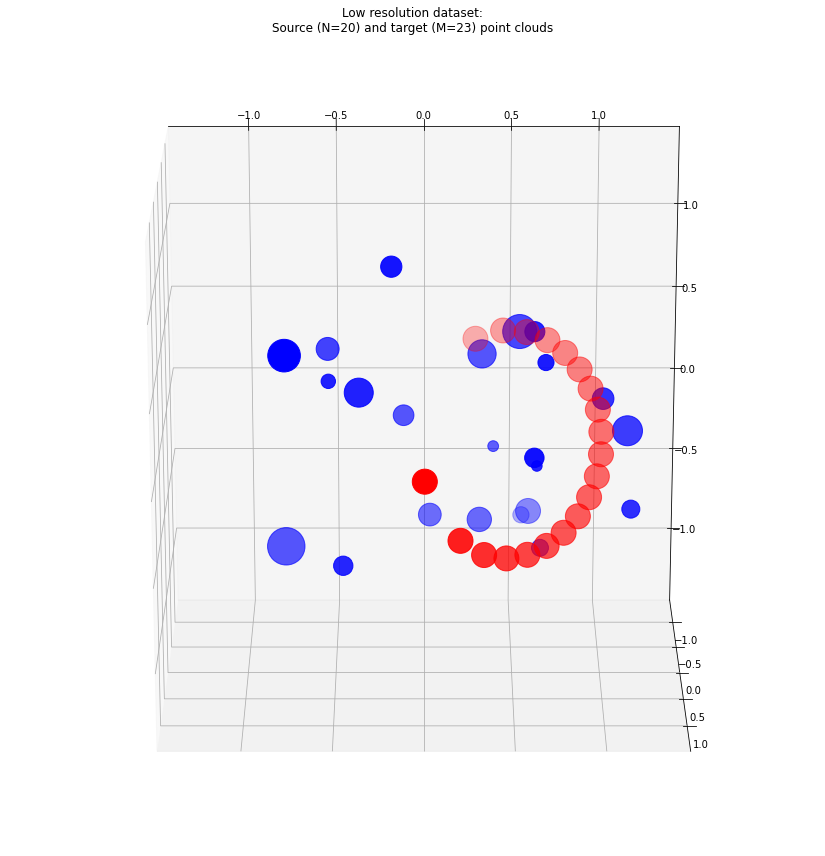

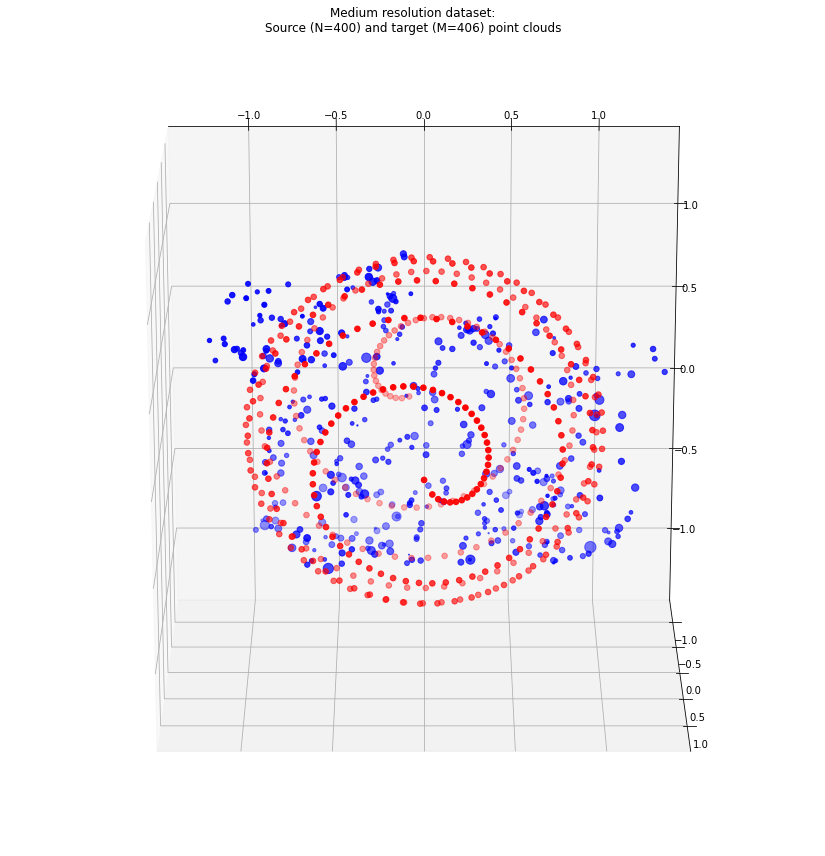

In [13]:
sources = [create_sphere(npoints) for npoints in [1e4, 5e4, 2e5, 8e5]]

import os

if not os.path.exists("data/dragon_recon/dragon_vrip_res4.ply"):
    import urllib.request

    urllib.request.urlretrieve(
        "http://graphics.stanford.edu/pub/3Dscanrep/dragon/dragon_recon.tar.gz",
        "data/dragon.tar.gz",
    )

    import shutil

    shutil.unpack_archive("data/dragon.tar.gz", "data")



# N.B.: Since Plyfile is far from being optimized, this may take some time!
targets = [
    load_ply_file(fname, offset=[-0.011, 0.109, -0.008], scale=0.04)
    for fname in [
        "data/dragon_recon/dragon_vrip_res4.ply",  # ~ 10,000 triangles
        "data/dragon_recon/dragon_vrip_res3.ply",  # ~ 50,000 triangles
        "data/dragon_recon/dragon_vrip_res2.ply",  # ~200,000 triangles
        #'data/dragon_recon/dragon_vrip.ply',     # ~800,000 triangles
    ]
]

def subsample(measure, decimation=500):
    weights, locations = measure
    weights, locations = weights[::decimation], locations[::decimation]
    weights = weights / weights.sum()
    return weights.contiguous(), locations.contiguous()


if not use_cuda:
    sources = [subsample(s) for s in sources]
    targets = [subsample(t) for t in targets]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection="3d")
display_cloud(ax, sources[0], "red")
display_cloud(ax, targets[0], "blue")
ax.set_title(
    "Low resolution dataset:\n"
    + "Source (N={:,}) and target (M={:,}) point clouds".format(
        len(sources[0][0]), len(targets[0][0])
    )
)
plt.tight_layout()

# sphinx_gallery_thumbnail_number = 2
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection="3d")
display_cloud(ax, sources[2], "red")
display_cloud(ax, targets[2], "blue")
ax.set_title(
    "Medium resolution dataset:\n"
    + "Source (N={:,}) and target (M={:,}) point clouds".format(
        len(sources[2][0]), len(targets[2][0])
    )
)
plt.tight_layout()

In [14]:

import numpy as np
import torch

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
numpy = lambda x: x.detach().cpu().numpy()

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from geomloss import SamplesLoss

#######################################################

from pykeops.torch import LazyTensor


def sinkhorn_loop(a_i, x_i, b_j, y_j, blur=0.01, nits=100, backend="keops"):
    """Straightforward implementation of the Sinkhorn-IPFP-SoftAssign loop in the log domain."""

    # Compute the logarithm of the weights (needed in the softmin reduction) ---
    loga_i, logb_j = a_i.log(), b_j.log()
    loga_i, logb_j = loga_i[:, None, None], logb_j[None, :, None]

    # Compute the cost matrix C_ij = (1/2) * |x_i-y_j|^2 -----------------------
    if backend == "keops":  # C_ij is a *symbolic* LazyTensor
        x_i, y_j = LazyTensor(x_i[:, None, :]), LazyTensor(y_j[None, :, :])
        C_ij = ((x_i - y_j) ** 2).sum(-1) / 2  # (N,M,1) LazyTensor

    elif (
        backend == "pytorch"
    ):  # C_ij is a *full* Tensor, with a quadratic memory footprint
        # N.B.: The separable implementation below is slightly more efficient than:
        # C_ij = ((x_i[:,None,:] - y_j[None,:,:]) ** 2).sum(-1) / 2

        D_xx = (x_i ** 2).sum(-1)[:, None]  # (N,1)
        D_xy = x_i @ y_j.t()  # (N,D)@(D,M) = (N,M)
        D_yy = (y_j ** 2).sum(-1)[None, :]  # (1,M)
        C_ij = (D_xx + D_yy) / 2 - D_xy  # (N,M) matrix of halved squared distances

        C_ij = C_ij[:, :, None]  # reshape as a (N,M,1) Tensor

    # Setup the dual variables -------------------------------------------------
    eps = blur ** 2  # "Temperature" epsilon associated to our blurring scale
    F_i, G_j = torch.zeros_like(loga_i), torch.zeros_like(
        logb_j
    )  # (scaled) dual vectors

    # Sinkhorn loop = coordinate ascent on the dual maximization problem -------
    for _ in range(nits):
        F_i = -((-C_ij / eps + (G_j + logb_j))).logsumexp(dim=1)[:, None, :]
        G_j = -((-C_ij / eps + (F_i + loga_i))).logsumexp(dim=0)[None, :, :]

    # Return the dual vectors F and G, sampled on the x_i's and y_j's respectively:
    return eps * F_i, eps * G_j


# Create a sinkhorn_solver "layer" with the same signature as SamplesLoss:
from functools import partial

sinkhorn_solver = lambda blur, nits, backend: partial(
    sinkhorn_loop, blur=blur, nits=nits, backend=backend
)

#######################################################

def full_benchmark(source, target, blur, maxtime=None):

    # Compute a suitable "ground truth" ----------------------------------------
    OT_solver = SamplesLoss(
        "sinkhorn",
        p=2,
        blur=blur,
        backend="online",
        scaling=0.999,
        debias=False,
        potentials=True,
    )
    _, _, ground_truth = benchmark_solver(OT_solver, blur, sources[0], targets[0])

    results = {}  # Dict of "timings vs errors" arrays

    # Compute statistics for the three backends of GeomLoss: -------------------

    for name in ["multiscale-1", "multiscale-5", "online", "tensorized"]:
        if name == "multiscale-1":
            backend, truncate = "multiscale", 1  # Aggressive "kernel truncation" scheme
        elif name == "multiscale-5":
            backend, truncate = "multiscale", 5  # Safe, default truncation rule
        else:
            backend, truncate = name, None

        OT_solvers = [
            SamplesLoss(
                "sinkhorn",
                p=2,
                blur=blur,
                scaling=scaling,
                truncate=truncate,
                backend=backend,
                debias=False,
                potentials=True,
            )
            for scaling in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
        ]

        results[name] = benchmark_solvers(
            "GeomLoss - " + name,
            OT_solvers,
            source,
            target,
            ground_truth,
            blur=blur,
            display=False,
            maxtime=maxtime,
        )

    # Compute statistics for a naive Sinkhorn loop -----------------------------

    for backend in ["pytorch", "keops"]:
        OT_solvers = [
            sinkhorn_solver(blur, nits=nits, backend=backend)
            for nits in [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
        ]

        results[backend] = benchmark_solvers(
            "Sinkhorn loop - " + backend,
            OT_solvers,
            source,
            target,
            ground_truth,
            blur=blur,
            display=False,
            maxtime=maxtime,
        )

    return results, ground_truth


#######################################################

def display_statistics(title, results, ground_truth, maxtime=None):
    """Displays a "error vs timing" plot in log-log scale."""

    curves = [
        ("pytorch", "Sinkhorn loop - PyTorch backend"),
        ("keops", "Sinkhorn loop - KeOps backend"),
        ("tensorized", "Sinkhorn with ε-scaling - PyTorch backend"),
        ("online", "Sinkhorn with ε-scaling - KeOps backend"),
        ("multiscale-5", "Sinkhorn multiscale - truncate=5 (safe)"),
        ("multiscale-1", "Sinkhorn multiscale - truncate=1 (fast)"),
    ]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.subplots()
    ax.set_title(title)
    ax.set_ylabel("Relative error made on the entropic Wasserstein distance")
    ax.set_yscale("log")
    ax.set_ylim(top=1e-1, bottom=1e-3)
    ax.set_xlabel("Time (s)")
    ax.set_xscale("log")
    ax.set_xlim(left=1e-3, right=maxtime)

    ax.grid(True, which="major", linestyle="-")
    ax.grid(True, which="minor", linestyle="dotted")

    for key, name in curves:
        timings, errors, costs = results[key]
        ax.plot(timings, np.abs(costs - ground_truth), label=name)

    ax.legend(loc="upper right")


def full_statistics(source, target, blur=0.01, maxtime=None):
    results, ground_truth = full_benchmark(source, target, blur, maxtime=maxtime)

    display_statistics(
        "Solving a {:,}-by-{:,} OT problem, with a blurring scale σ = {:}".format(
            len(source[0]), len(target[0]), blur
        ),
        results,
        ground_truth,
        maxtime=maxtime,
    )

    return results, ground_truth

Benchmarking the "GeomLoss - multiscale-1" family of OT solvers - ground truth = 1.114816:
1-th solver : t = 0.0041, error on the constraints = 0.026, cost = 1.117158
2-th solver : t = 0.0039, error on the constraints = 0.020, cost = 1.116267
3-th solver : t = 0.0046, error on the constraints = 0.012, cost = 1.115115
4-th solver : t = 0.0062, error on the constraints = 0.010, cost = 1.114980
5-th solver : t = 0.0060, error on the constraints = 0.007, cost = 1.114866
6-th solver : t = 0.0083, error on the constraints = 0.005, cost = 1.114833
7-th solver : t = 0.0336, error on the constraints = 0.002, cost = 1.114814

Benchmarking the "GeomLoss - multiscale-5" family of OT solvers - ground truth = 1.114816:
1-th solver : t = 0.0023, error on the constraints = 0.026, cost = 1.117158
2-th solver : t = 0.0024, error on the constraints = 0.020, cost = 1.116267
3-th solver : t = 0.0026, error on the constraints = 0.012, cost = 1.115115
4-th solver : t = 0.0031, error on the constraints = 0.01

({'multiscale-1': (array([0.0040915 , 0.00392246, 0.0046308 , 0.00623918, 0.0060153 ,
          0.00832796, 0.03363752]),
   array([0.02622071, 0.0201094 , 0.01221164, 0.01034325, 0.00745579,
          0.00517652, 0.00154611]),
   array([1.11715758, 1.11626673, 1.1151154 , 1.11498034, 1.11486602,
          1.11483264, 1.11481428])),
  'multiscale-5': (array([0.00231552, 0.00235295, 0.00256348, 0.0031395 , 0.00794268,
          0.00876832, 0.03343201]),
   array([0.02622071, 0.0201094 , 0.01221164, 0.01034325, 0.00745579,
          0.00517652, 0.00154611]),
   array([1.11715758, 1.11626673, 1.1151154 , 1.11498034, 1.11486602,
          1.11483264, 1.11481428])),
  'online': (array([0.00150704, 0.00178742, 0.00215364, 0.00260568, 0.00414324,
          0.00752878, 0.03676486]),
   array([0.02614781, 0.0200291 , 0.01215924, 0.01027724, 0.00735674,
          0.00503827, 0.001269  ]),
   array([1.11717629, 1.11628222, 1.11512506, 1.1149888 , 1.11487234,
          1.11483753, 1.11481583])),
 

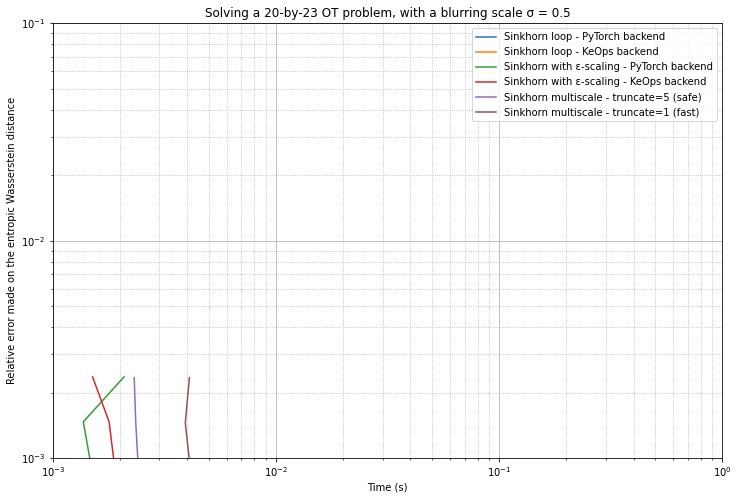

In [19]:
maxtime = 100 if use_cuda else 1

full_statistics(sources[0], targets[0], blur=.5, maxtime=maxtime)